In [1]:
#Import Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rx
from rioxarray.merge import merge_arrays

In [2]:
# geodataframe
balt_bg = gpd.read_file("model_inputs/bg_baltimore.csv", 
                        GEOM_POSSIBLE_NAMES="geometry",
                        KEEP_GEOM_COLUMNS="NO")

balt_bg = balt_bg.set_crs('epsg:3857')
bg_visual = balt_bg.to_crs('epsg:4269')


<Axes: >

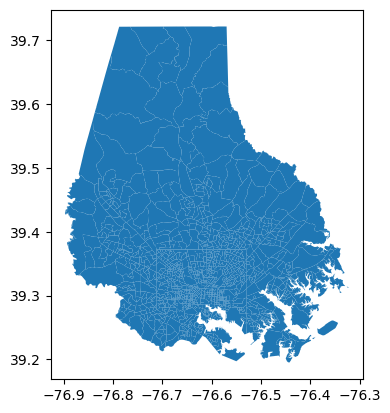

In [3]:
#visualize geodataframe
bg_visual.plot()

In [4]:
#open tif file
raster_base = rx.open_rasterio("flood_inputs/FastFlood/Base/Surge-Baltimore2-10m_Base_275.tif")
raster_levee = rx.open_rasterio("flood_inputs/FastFlood/Levee/Surge-Baltimore2-10m_All_275.tif")

rasters = [raster_base, raster_levee]
#raster.rio.crs
#combine rasters
#ds_grid = [[raster_base, raster_levee], [raster_base, raster_levee]]
#xr.combine_nested(ds_grid,concat_dim=["x","y"])
#raster.rio.clip_box(-77, 39.15, -76.3, 39.9)


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

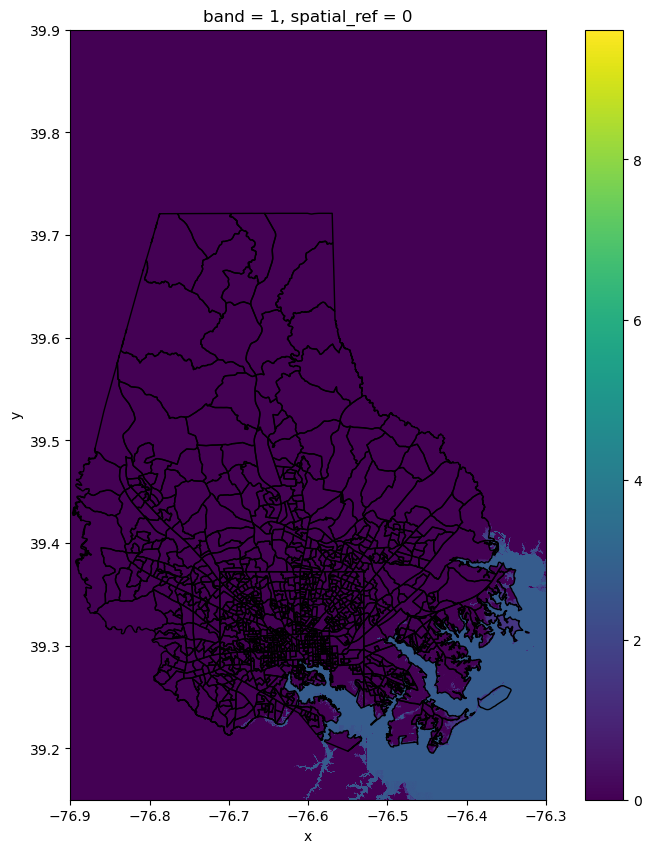

In [5]:
f, ax = plt.subplots(1, figsize=(10, 10))
raster_base.plot(ax=ax)
bg_visual.plot(ax=ax, facecolor = "none")

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

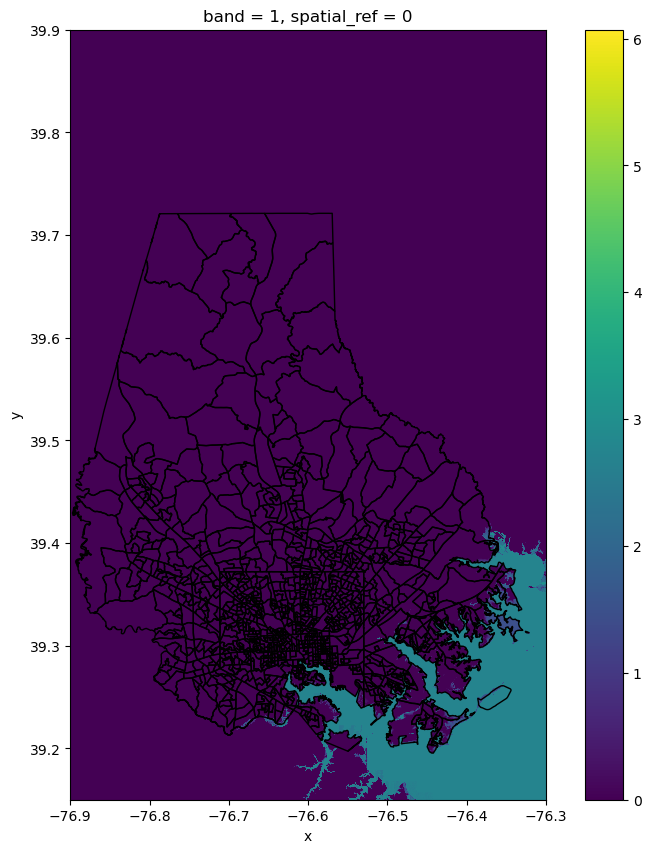

In [6]:

f, ax = plt.subplots(1, figsize=(10, 10))
raster_levee.plot(ax=ax)
bg_visual.plot(ax=ax, facecolor = "none")

In [7]:

band = rasters[0][0]
x, y, extent = band.x.values, band.y.values, band.values
x, y = np.meshgrid(x, y)
x, y, extent = x.flatten(), y.flatten(), extent.flatten()

#Convert to point geometries 
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs=band.rio.crs))
centroids['base'] = extent

#band_list = [[]for i in range(len(rasters[1:]))]
band_dict = {}
for ras in rasters[1:]:
    #get first band of raster
    band = ras[0]
    extent = band.values.flatten()

    ##add to list
    #need to figure out better naming sequence
    band_dict['levee'] = extent

band_df = pd.DataFrame.from_dict(band_dict)
centroids = pd.concat([centroids, band_df], axis = 1)

    
    


In [9]:
#join centroid geometries with block group geometries
bg_flood_area = gpd.sjoin(bg_visual,centroids)



In [10]:
#determine whether max flood depth occurrence within each block group
bg_flood_max = bg_flood_area[["GISJOIN","base","levee"]].groupby('GISJOIN').max()
#bg_flood_max = bg_flood_max.round({'extent':0})

#Rejoin block group geometries
balt_flood = bg_visual[["GISJOIN","geometry"]].merge(bg_flood_max, on='GISJOIN')

<Axes: >

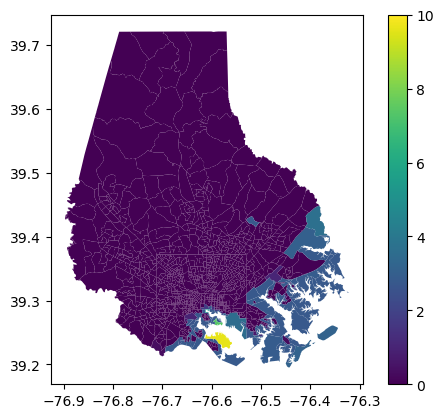

In [15]:
balt_flood.plot(column = 'base',legend=True, vmin = 0, vmax = 10)

<Axes: >

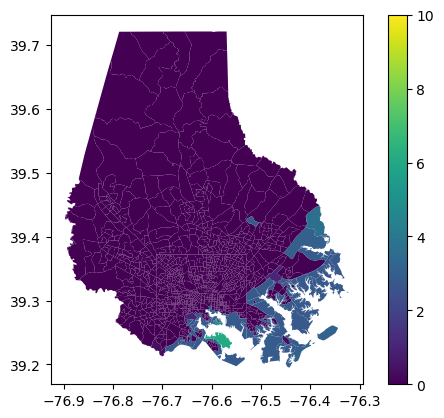

In [14]:
balt_flood.plot(column = 'levee',legend=True, vmin = 0, vmax = 10)

In [33]:
import os
directory = "flood_inputs/FastFlood/Base" 
#Extract surge level from filename
file_0 = os.listdir(directory)[0]
surge_name = ""
surge_name = surge_name.join([*file_0.split('_')[2]][0:3])
surge_name = str(int(surge_name)/100)

ras = rx.open_rasterio(os.path.join(directory, file_0))
band = ras[0]
x, y, extent = band.x.values, band.y.values, band.values
x, y = np.meshgrid(x, y)
x, y, extent = x.flatten(), y.flatten(), extent.flatten()

#Convert to point geometries 
base_fd = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs=band.rio.crs))
base_fd[surge_name] = extent

band_dict = {}
for filename in os.listdir(directory)[1:]:
    raster = rx.open_rasterio(os.path.join(directory, filename))
#get first band of raster
    band = raster[0]
    extent = band.values.flatten()

    surge_name = ""
    surge_name = surge_name.join([*filename.split('_')[2]][0:3])
    surge_name = str(int(surge_name)/100)
    ##add to list
    band_dict[surge_name] = extent

band_df = pd.DataFrame.from_dict(band_dict)
base_fd = pd.concat([base_fd, band_df], axis = 1)

    

In [32]:
file = os.listdir(directory)[0]
surge_name = ""
surge_name = surge_name.join([*file.split('_')[2]][0:3])
surge_name = str(int(surge_name)/100)

'0.5'

In [34]:
base_fd

,geometry,0.5
0,POINT (-76.89995 39.89995),0.0
1,POINT (-76.89986 39.89995),0.0
2,POINT (-76.89977 39.89995),0.0
3,POINT (-76.89968 39.89995),0.0
4,POINT (-76.89958 39.89995),0.0
...,...,...
52487995,POINT (-76.30042 39.15005),0.5
52487996,POINT (-76.30032 39.15005),0.5
52487997,POINT (-76.30023 39.15005),0.5
52487998,POINT (-76.30014 39.15005),0.5
